Phase-contrast ET with ODL
==========================

Import some modules
-------------------

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import os
import odl
from odl.contrib import etomo
from odl.contrib.mrc import FileReaderMRC

Read phantom and data
---------------------

We have used [TEM-Simulator](http://tem-simulator.sourceforge.net/) to a generate phantom and corresponding ET data in the [MRC file-format](http://www.ccpem.ac.uk/mrc_format/mrc2014.php), based on an atomic model for a RNA Polymerase particle (entry [1I3Q](https://www.rcsb.org/structure/1i3q) in the PDB).


In [78]:
# Read phantom and data
dir_path = os.path.abspath('TEM/Data/Simulated/One_particle_RNA/dose_5000')
file_path_phantom = os.path.join(dir_path, 'rna_phantom.mrc')
file_path_tiltseries = os.path.join(dir_path, 'tiltseries.mrc')

In [79]:
# Convert phantom and data from mrc to numpy arrays
with FileReaderMRC(file_path_phantom) as phantom_reader:
    phantom_header, phantom_asarray = phantom_reader.read()
with FileReaderMRC(file_path_tiltseries) as tiltseries_reader:
    tiltseries_header, data_asarray = tiltseries_reader.read()

Set parameters for the EM experiment
------------------------------------

In [80]:
# Diameter and height of the sample
sample_diam = 1200e-9  # m
sample_height = 150e-9  # m

# Parameters for the electron beam
acc_voltage = 200.0e3  # V
mean_energy_spread = 1.3  # V
wave_length = 0.0025e-9  # m
wave_number = 2 * np.pi / wave_length

# Parameters for the optical system
M = 25000.0
aper_rad = 0.5*40e-6  # m
focal_length = 2.7e-3  # m
spherical_abe = 2.1e-3  # m
defocus = 3e-6  # m
chromatic_abe = 2.2e-3  # m
aper_angle = 0.1e-3  # rad

# Some physical constants
e_mass = 9.11e-31  # kg
e_charge = 1.602e-19  # C
planck_bar = 1.059571e-34  # Js/rad

# Use nanometers instead of meters as unit of lenght
rescale_factor = 1e9
sigma = e_mass * e_charge / (wave_number * planck_bar ** 2)
obj_magnitude = sigma / rescale_factor

# Size of detector pixels (before rescaling to account for magnification)
det_size = 16e-6  # m

# Number of tilt-angles
num_angles = 61

Set up the forward operator in ODL
----------------------------------

In [81]:
# Reconstruction space: discretized functions on a cuboid
reco_space = odl.uniform_discr(min_pt=[-rescale_factor*95e-9/4,
                                       -rescale_factor*100e-9/4,
                                       -rescale_factor*80e-9/4],
                               max_pt=[rescale_factor*95e-9/4,
                                       rescale_factor*100e-9/4,
                                       rescale_factor*80e-9/4],
                               shape=[95, 100, 80])

# Make a 3d single-axis parallel beam geometry with flat detector
# Angles: uniformly spaced, n = 61, min = -pi/3, max = pi/3
angle_partition = odl.uniform_partition(-np.pi/3, np.pi/3, num_angles)
detector_partition = odl.uniform_partition([-rescale_factor*det_size/M * 200/2] * 2,
                                           [rescale_factor*det_size/M * 200/2] * 2, [200] * 2)

# The x-axis is the tilt-axis.
geometry = odl.tomo.Parallel3dAxisGeometry(angle_partition, detector_partition,
                                           axis=(1, 0, 0),
                                           det_pos_init=(0, 0, -1),
                                           det_axes_init=((1, 0, 0),
                                                          (0, 1, 0)))

# Ray transform
ray_trafo = etomo.BlockRayTransform(reco_space, geometry)

# The image-formation operator models the optics and the detector
# of the electron microscope.
imageFormation_op = etomo.make_imageFormationOp(ray_trafo.range, 
                                                wave_number, spherical_abe,
                                                defocus,
                                                rescale_factor=rescale_factor,
                                                obj_magnitude=obj_magnitude,
                                                abs_phase_ratio=abs_phase_ratio,
                                                aper_rad=aper_rad,
                                                aper_angle=aper_angle,
                                                focal_length=focal_length,
                                                mean_energy_spread=mean_energy_spread,
                                                acc_voltage=acc_voltage,
                                                chromatic_abe=chromatic_abe,
                                                normalize=True)

# Define a spherical mask to implement support constraint.
mask = reco_space.element(etomo.spherical_mask,
                          radius=rescale_factor * 10.0e-9)

# Define forward operator as a composition
forward_op = imageFormation_op * ray_trafo

Take a look at the phantom
--------------------------

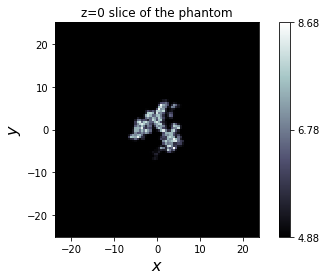

<Figure size 432x288 with 0 Axes>

In [82]:
phantom = reco_space.element(phantom_asarray)
phantom_fig = phantom.show(coords=[None, None, 0], title='z=0 slice of the phantom')

Take a look at the data
-----------------------

In [83]:
# Make an ODL discretized function of the MRC data
data = forward_op.range.element(np.transpose(data_asarray, (2, 0, 1)))

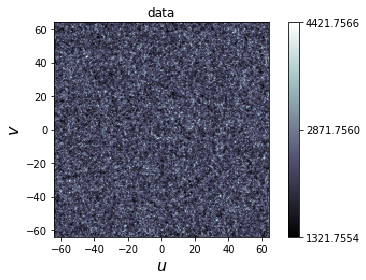

<Figure size 432x288 with 0 Axes>

In [84]:
data_fig = data.show(coords=[0, None, None], title='data')

In [85]:
# As a pre-processing step we correct for diffrent pathlenghts of the electrons through the buffer
data = etomo.buffer_correction(data)

Prepare reconstruction 
----------------------
We use a method of Kaczmarz-type. Details can be found in this [paper](https://doi.org/10.1088/1361-6420/aade22).

In [86]:
num_angles_per_block = 1
kaczmarz_plan = etomo.make_kaczmarz_plan(num_angles,
                                         block_length=num_angles_per_block,
                                         method='mls')
ray_trafo_block = ray_trafo.get_sub_operator(kaczmarz_plan[0])
F_post = etomo.make_imageFormationOp(ray_trafo_block.range,
                                     wave_number, spherical_abe,
                                     defocus,
                                     rescale_factor=rescale_factor,
                                     obj_magnitude=obj_magnitude,
                                     abs_phase_ratio=abs_phase_ratio,
                                     aper_rad=aper_rad, aper_angle=aper_angle,
                                     focal_length=focal_length,
                                     mean_energy_spread=mean_energy_spread,
                                     acc_voltage=acc_voltage,
                                     chromatic_abe=chromatic_abe,
                                     normalize=True)

F_pre = odl.MultiplyOperator(mask, reco_space, reco_space)
get_op = etomo.make_Op_blocks(kaczmarz_plan, ray_trafo, Op_pre=F_pre,
                              Op_post=F_post)
get_data = etomo.make_data_blocks(data, kaczmarz_plan)
get_proj_op = etomo.make_Op_blocks(kaczmarz_plan, ray_trafo, Op_pre=F_pre,
                                   Op_post=None)

# Optional nonnegativity-constraint
nonneg_projection = etomo.get_nonnegativity_projection(reco_space)

# Set hyper-parameters for the reconstruction
regpar = 2e3
gamma_H1 = 0.9
num_cycles = 3

# Set starting guess to zero
reco = ray_trafo.domain.zero()

Run reconstruction
------------------

In [87]:
etomo.kaczmarz_SART_method(get_proj_op, reco, get_data, len(kaczmarz_plan),
                           regpar*obj_magnitude ** 2,
                           imageFormationOp=F_post, gamma_H1=gamma_H1,
                           niter_CG=30,
                           num_cycles=num_cycles, projection=nonneg_projection)

Inspect the result
------------------

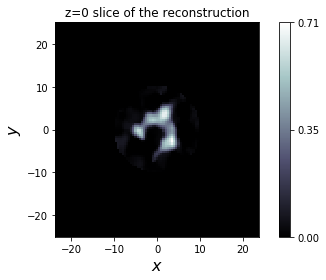

<Figure size 432x288 with 0 Axes>

In [88]:
reco_fig = reco.show(title='z=0 slice of the reconstruction',
                                 coords=[None, None, 0])